<a href="https://colab.research.google.com/github/TheCaveOfAdullam/study3/blob/main/test_0628_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tensorflow_model_optimization

In [3]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import os
import time
import psutil
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.utils import to_categorical
import keras.backend as K
import tensorflow_model_optimization as tfmot
import h5py
from keras.regularizers import l2
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# 기본 경로 설정
base_dir = '/content/drive/MyDrive/ship_data'
categories = ['normal', 'fault_BB', 'fault_RI', 'fault_SM']

# 데이터 로드 및 전처리 함수 정의
def load_data(base_dir, split):
    X = []
    y = []
    split_dir = os.path.join(base_dir, split)
    for category in categories:
        category_dir = os.path.join(split_dir, category)
        for file in os.listdir(category_dir):
            file_path = os.path.join(category_dir, file)
            data = pd.read_csv(file_path, header=None).values
            data = pd.to_numeric(data.flatten(), errors='coerce').reshape(-1, data.shape[1])
            data = np.nan_to_num(data).astype('float32')  # NaN 값을 0으로 대체하고, float32로 변환
            X.append(data)
            y.append(category)
    return np.array(X), np.array(y)

# 데이터 로드
X_train, y_train = load_data(base_dir, 'train')
X_val, y_val = load_data(base_dir, 'validation')
X_test, y_test = load_data(base_dir, 'test')

# 데이터 차원 변경 (CNN 입력 형식에 맞게)
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# 레이블 인코딩
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# 원-핫 인코딩
y_train_categorical = to_categorical(y_train_encoded)
y_val_categorical = to_categorical(y_val_encoded)
y_test_categorical = to_categorical(y_test_encoded)

In [5]:
# 기본 CNN 모델 정의
def create_model():
    model = Sequential(name='CNN_Model')
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu',
                     input_shape=(X_train.shape[1], X_train.shape[2]),
                     kernel_regularizer=l2(0.0001), name='conv1'))  # 정규화 항목 유지
    model.add(MaxPooling1D(pool_size=2, name='maxpool1'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', name='conv2'))  # 정규화 항목 제거
    model.add(MaxPooling1D(pool_size=2, name='maxpool2'))
    model.add(Flatten(name='flatten'))
    model.add(Dense(100, activation='relu', name='dense1'))
    model.add(Dropout(0.5, name='dropout'))  # 드롭아웃 비율 유지
    model.add(Dense(len(categories), activation='softmax', name='output'))
    return model

# Create and compile the model
model = create_model()
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
# Train the model and capture the history
history = model.fit(X_train, y_train_categorical, epochs=5, batch_size=32, validation_data=(X_val, y_val_categorical))

Epoch 1/5
219/219 [==============================] - 77s 348ms/step - loss: 1.5477 - accuracy: 0.4887 - val_loss: 1.0672 - val_accuracy: 0.5869
Epoch 2/5
219/219 [==============================] - 76s 347ms/step - loss: 0.6876 - accuracy: 0.7012 - val_loss: 0.1818 - val_accuracy: 0.9617
Epoch 3/5
219/219 [==============================] - 77s 350ms/step - loss: 0.4167 - accuracy: 0.8098 - val_loss: 0.0891 - val_accuracy: 0.9773
Epoch 4/5
219/219 [==============================] - 78s 354ms/step - loss: 0.3691 - accuracy: 0.8322 - val_loss: 0.1271 - val_accuracy: 0.9624
Epoch 5/5
219/219 [==============================] - 78s 356ms/step - loss: 0.3369 - accuracy: 0.8545 - val_loss: 0.0955 - val_accuracy: 0.9789


In [7]:
# 원래 모델 저장
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
# 가지치기 함수 정의
def prune_weights(model, pruning_percentage=0.8):
    for layer in model.layers:
        if isinstance(layer, Dense):
            weights, biases = layer.get_weights()

            # 가중치의 절대값 기준으로 임계값 계산
            abs_weights = np.abs(weights)
            threshold = np.percentile(abs_weights, pruning_percentage * 100)

            # 임계값 이하의 가중치를 0으로 설정
            new_weights = np.where(abs_weights < threshold, 0, weights)

            # 가지치기된 가중치로 레이어 설정
            layer.set_weights([new_weights, biases])

    return model

# 가지치기된 모델
pruned_model = prune_weights(model, pruning_percentage=0.8)

In [9]:
# 가지치기된 모델 재훈련
pruned_history = pruned_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

pruned_history = pruned_model.fit(X_train, y_train_categorical, epochs=5, batch_size=32, validation_data=(X_val, y_val_categorical))

Epoch 1/5
219/219 [==============================] - 78s 351ms/step - loss: 0.3462 - accuracy: 0.8559 - val_loss: 0.2086 - val_accuracy: 0.8818
Epoch 2/5
219/219 [==============================] - 76s 346ms/step - loss: 0.2802 - accuracy: 0.8781 - val_loss: 0.0649 - val_accuracy: 0.9867
Epoch 3/5
219/219 [==============================] - 76s 348ms/step - loss: 0.2434 - accuracy: 0.8926 - val_loss: 0.0620 - val_accuracy: 0.9797
Epoch 4/5
219/219 [==============================] - 77s 350ms/step - loss: 0.2264 - accuracy: 0.8991 - val_loss: 0.0371 - val_accuracy: 0.9875
Epoch 5/5
219/219 [==============================] - 77s 354ms/step - loss: 0.2385 - accuracy: 0.9043 - val_loss: 0.0682 - val_accuracy: 0.9844


In [10]:
# 가지치기된 모델의 가중치 저장 (희소성 적용)
def save_sparse_model(model, file_path):
    with h5py.File(file_path, 'w') as f:
        for layer in model.layers:
            if isinstance(layer, Dense) or isinstance(layer, Conv1D):
                weights, biases = layer.get_weights()
                # 0이 아닌 가중치만 저장
                non_zero_indices = weights != 0
                non_zero_weights = weights[non_zero_indices]
                f.create_dataset(layer.name + '_weights', data=non_zero_weights)
                f.create_dataset(layer.name + '_biases', data=biases)
                f.create_dataset(layer.name + '_non_zero_indices', data=non_zero_indices)
            else:
                # 다른 레이어는 그대로 저장
                weights = layer.get_weights()
                for i, weight in enumerate(weights):
                    f.create_dataset(layer.name + f'_weights_{i}', data=weight)

# 희소성 적용한 모델 저장
save_sparse_model(pruned_model, 'model_after_pruning_sparse.h5')

# 희소성 적용 모델 로드 함수
def load_sparse_model(file_path, original_model):
    with h5py.File(file_path, 'r') as f:
        for layer in original_model.layers:
            if isinstance(layer, Dense) or isinstance(layer, Conv1D):
                non_zero_weights = f[layer.name + '_weights'][:]
                biases = f[layer.name + '_biases'][:]
                non_zero_indices = f[layer.name + '_non_zero_indices'][:]
                original_weights = np.zeros(layer.get_weights()[0].shape)
                original_weights[non_zero_indices] = non_zero_weights
                layer.set_weights([original_weights, biases])
            else:
                weights = []
                i = 0
                while f'{layer.name}_weights_{i}' in f:
                    weights.append(f[layer.name + f'_weights_{i}'][:])
                    i += 1
                layer.set_weights(weights)

# 희소성 적용 모델 로드
model_for_evaluation = create_model()
load_sparse_model('model_after_pruning_sparse.h5', model_for_evaluation)

# 모델 컴파일
model_for_evaluation.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# 모델 크기 비교
original_model_size = os.path.getsize('model.h5') / (1024 * 1024)
sparse_model_size = os.path.getsize('model_after_pruning_sparse.h5') / (1024 * 1024)
print(f"Original Model Size: {original_model_size:.2f} MB")
print(f"Sparse Pruned Model Size: {sparse_model_size:.2f} MB")

Original Model Size: 439.50 MB
Sparse Pruned Model Size: 69.93 MB


In [12]:
# 원본 모델 추론 시간 및 메모리 사용량 측정
process = psutil.Process(os.getpid())
memory_usage_before_inference_original = process.memory_info().rss / (1024 * 1024)

start_time = time.time()
y_pred_categorical_original = model.predict(X_test)
end_time = time.time()
inference_time_original = end_time - start_time

memory_usage_after_inference_original = process.memory_info().rss / (1024 * 1024)
memory_usage_during_inference_original = memory_usage_after_inference_original - memory_usage_before_inference_original

print(f"Original Model Memory Usage - Before: {memory_usage_before_inference_original:.2f} MB, After: {memory_usage_after_inference_original:.2f} MB")
print(f"Original Model Inference Time: {inference_time_original:.2f} seconds")
print(f"Original Model Memory Usage During Inference: {memory_usage_during_inference_original:.2f} MB")

40/40 [==============================] - 3s 72ms/step
Original Model Memory Usage - Before: 8633.06 MB, After: 8794.47 MB
Original Model Inference Time: 3.25 seconds
Original Model Memory Usage During Inference: 161.41 MB


In [13]:
# 가지치기된 모델 추론 시간 및 메모리 사용량 측정
memory_usage_before_inference_pruned = process.memory_info().rss / (1024 * 1024)

start_time = time.time()
y_pred_categorical_after = model_for_evaluation.predict(X_test)
end_time = time.time()
inference_time_pruned = end_time - start_time

memory_usage_after_inference_pruned = process.memory_info().rss / (1024 * 1024)
memory_usage_during_inference_pruned = memory_usage_after_inference_pruned - memory_usage_before_inference_pruned

print(f"Pruned Model Memory Usage - Before: {memory_usage_before_inference_pruned:.2f} MB, After: {memory_usage_after_inference_pruned:.2f} MB")
print(f"Pruned Model Inference Time: {inference_time_pruned:.2f} seconds")
print(f"Pruned Model Memory Usage During Inference: {memory_usage_during_inference_pruned:.2f} MB")

40/40 [==============================] - 3s 71ms/step
Pruned Model Memory Usage - Before: 8794.47 MB, After: 8888.00 MB
Pruned Model Inference Time: 3.16 seconds
Pruned Model Memory Usage During Inference: 93.53 MB


In [14]:
# 검증 데이터 평가
val_loss_after, val_accuracy_after = model_for_evaluation.evaluate(X_val, y_val_categorical)
print(f"Validation Loss: {val_loss_after:.4f}")
print(f"Validation Accuracy: {val_accuracy_after:.4f}")

40/40 [==============================] - 3s 74ms/step - loss: 0.0682 - accuracy: 0.9844
Validation Loss: 0.0682
Validation Accuracy: 0.9844


In [15]:
# 테스트 데이터 평가
test_loss_after, test_accuracy_after = model_for_evaluation.evaluate(X_test, y_test_categorical)
print(f"Test Loss: {test_loss_after:.4f}")
print(f"Test Accuracy: {test_accuracy_after:.4f}")

40/40 [==============================] - 3s 70ms/step - loss: 0.0794 - accuracy: 0.9781
Test Loss: 0.0794
Test Accuracy: 0.9781


In [16]:
# 테스트 데이터 평가
test_loss, test_accuracy = model.evaluate(X_test, y_test_categorical)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

40/40 [==============================] - 3s 67ms/step - loss: 0.0794 - accuracy: 0.9781
Test Loss: 0.07936505973339081
Test Accuracy: 0.978090763092041


In [17]:
# 혼동 행렬 및 성능 지표 출력 (테스트 데이터)
y_pred_after = np.argmax(y_pred_categorical_after, axis=1)
conf_matrix_test_after = confusion_matrix(y_test_encoded, y_pred_after)
class_report_test_after = classification_report(y_test_encoded, y_pred_after, target_names=categories)
f1_score_after = f1_score(y_test_encoded, y_pred_after, average='weighted')

In [18]:
# 성능 비교 출력
performance_comparison = {
    'Metric': ['Model Size (MB)', 'Original Memory Usage (MB)', 'Pruned Memory Usage (MB)', 'Original Inference Time (s)', 'Pruned Inference Time (s)', 'Validation Loss', 'Validation Accuracy', 'Test Loss', 'Test Accuracy', 'F1 Score'],
    'Values': [sparse_model_size, memory_usage_during_inference_original, memory_usage_during_inference_pruned, inference_time_original, inference_time_pruned, val_loss_after, val_accuracy_after, test_loss_after, test_accuracy_after, f1_score_after]
}

performance_df = pd.DataFrame(performance_comparison)
print("\nPerformance Comparison:")
print(performance_df)


Performance Comparison:
                        Metric      Values
0              Model Size (MB)   69.928772
1   Original Memory Usage (MB)  161.406250
2     Pruned Memory Usage (MB)   93.531250
3  Original Inference Time (s)    3.252395
4    Pruned Inference Time (s)    3.163519
5              Validation Loss    0.068159
6          Validation Accuracy    0.984351
7                    Test Loss    0.079365
8                Test Accuracy    0.978091
9                     F1 Score    0.977734


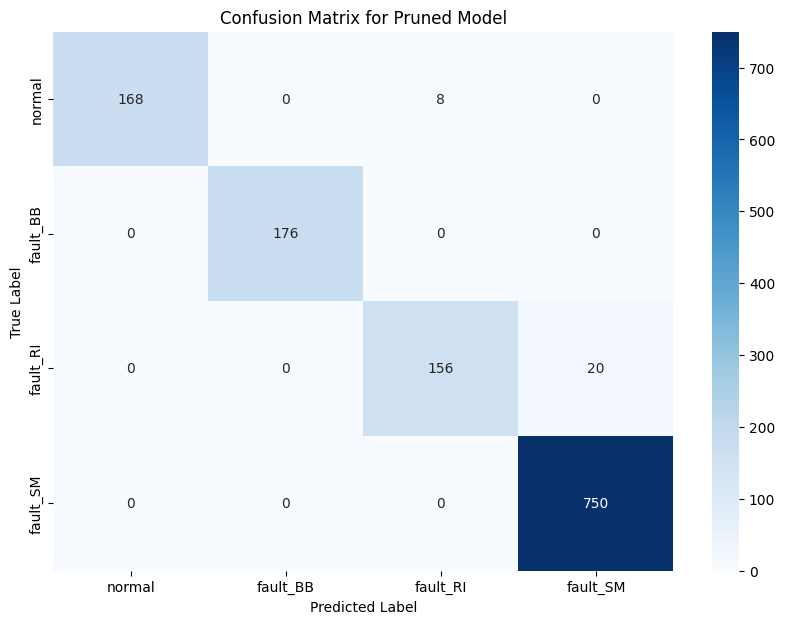

In [19]:
# 혼동 행렬 시각화
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_test_after, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Pruned Model')
plt.show()

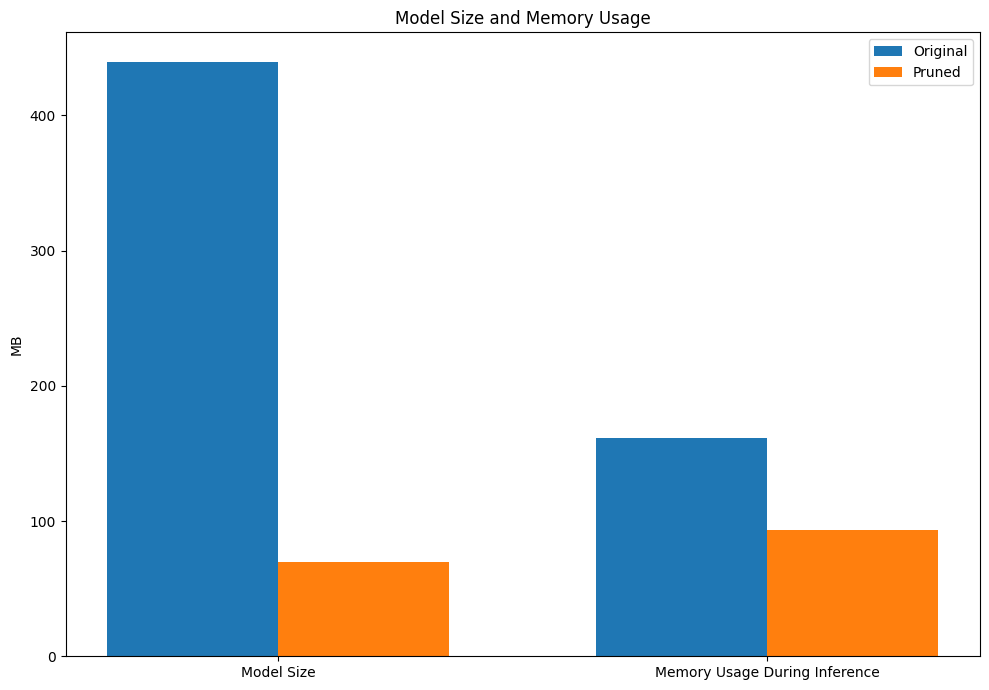

In [20]:
# 모델 사이즈 및 메모리 사용량 비교 막대 그래프
labels = ['Model Size', 'Memory Usage During Inference']
original_values = [original_model_size, memory_usage_during_inference_original]
pruned_values = [sparse_model_size, memory_usage_during_inference_pruned]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 7))
rects1 = ax.bar(x - width/2, original_values, width, label='Original')
rects2 = ax.bar(x + width/2, pruned_values, width, label='Pruned')

ax.set_ylabel('MB')
ax.set_title('Model Size and Memory Usage')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

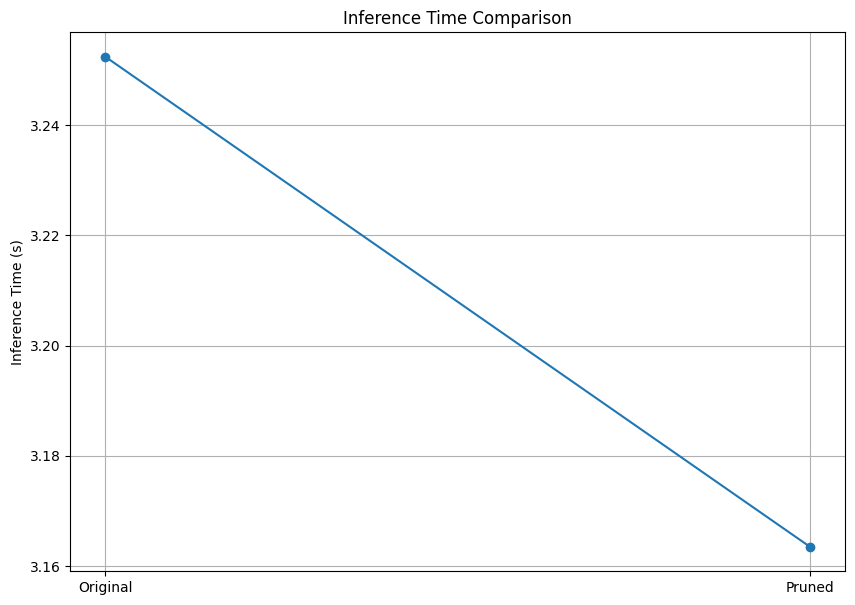

In [21]:
# 추론 시간 비교 선 그래프
inference_times = {'Original': inference_time_original, 'Pruned': inference_time_pruned}
names = list(inference_times.keys())
values = list(inference_times.values())

plt.figure(figsize=(10, 7))
plt.plot(names, values, marker='o')
plt.ylabel('Inference Time (s)')
plt.title('Inference Time Comparison')
plt.grid(True)
plt.show()

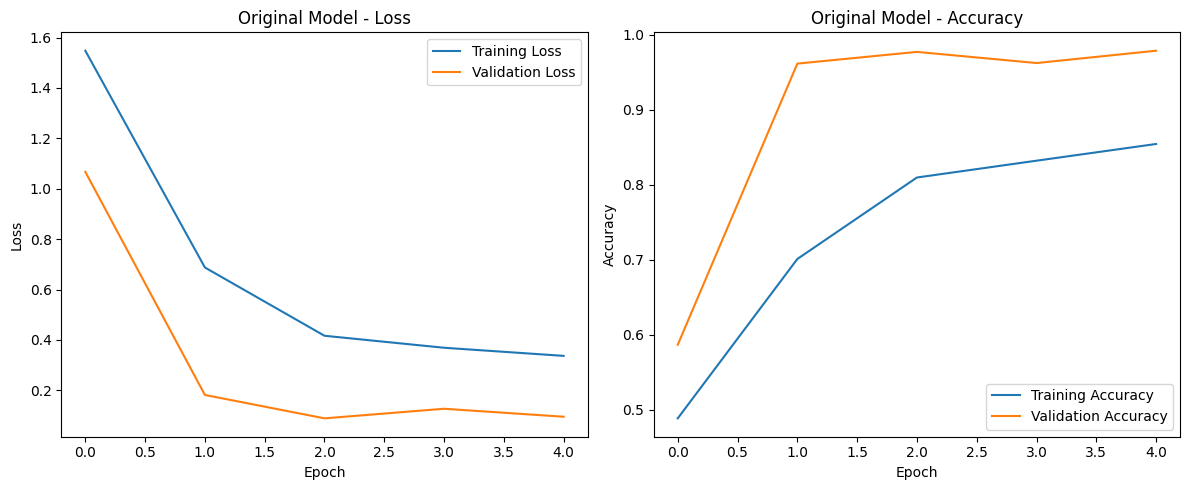

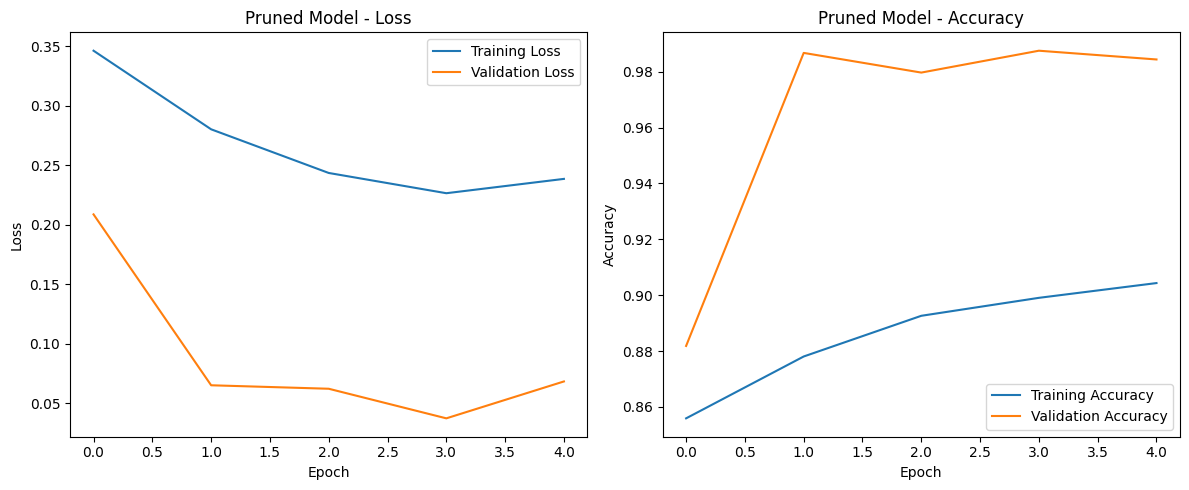

In [22]:
# 모델 학습 과정 시각화
def plot_training_history(history, title):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title + ' - Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(title + ' - Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history, 'Original Model')
plot_training_history(pruned_history, 'Pruned Model')